# Momentum算法和NAG算法实现
## 姓名：杨丰远； 学号：201928013229022

In [1]:
import numpy as np
from sympy import *
from matplotlib import pyplot as plt
from matplotlib import ticker
from mpl_toolkits.mplot3d import Axes3D

------------------

## 第1题（Momentum算法）
### a.动量法
引入动量（momentum）有两方面好处:
1. 解决峡谷、鞍点问题  
2. 可用于SGD加速  

实际上可以认为动量（momentum）法也是在模拟二阶梯度信息,只是是一种廉价的方式(不是直接计算,而是引入"惯性"的思想)  
具体迭代公式:  
$\left\{\begin{array}{l}v_{j}=\gamma v_{j-1}-\eta g\left(w_{j-1}\right) \\ w_{j}=w_{j-1}+v_{j}\end{array}\right.$  
其中$\gamma$为折扣因子，表示历史梯度的影响

### b.目标函数
$$f(x)=\sum_{i=1}^{N-1}\left[\left(1-x_{i}\right)^{2}+100\left(x_{i+1}-x_{i}^{2}\right)^{2}\right] \quad \forall x \in R^{N}$$ 
该目标函数是著名的Rosenbrock函数，是一个数学最优化中专门用来测试最优化算法性能的非凸函数。也称为Rosenbrock山谷或Rosenbrock香蕉函数，也简称为**香蕉函数**，因为其全域最小值位于抛物线形的山谷中（香蕉型山谷）。

In [2]:
def rosenbrock_func(N):
    x_symbols = symbols("x1:%d"%(N+1))
    x = np.array(x_symbols)
    f = 0
    for i in range(N-1):
        f += ((1-x[i])**2 + 100*(x[i+1] - x[i]**2)**2)
    df = [diff(f, x_) for x_ in x]
    return f,df,x

f_2, df_2, x_2 = rosenbrock_func(N = 2)
print(f_2)

(1 - x1)**2 + 100*(-x1**2 + x2)**2


如上即是N=2时的Rosenbrock函数形式，该形式可以做三维可视化如下，对之有一个形象的认识：

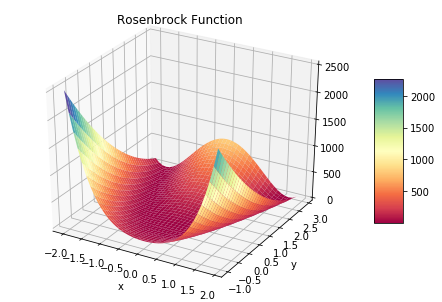

In [3]:
fig = plt.figure()
ax = Axes3D(fig)
x=np.arange(-2,2,0.1)
y=np.arange(-1,3,0.1)
X, Y = np.meshgrid(x, y)
# N=2时的Rosenbrock函数
Z=(1-X)**2 + 100 * (Y - X**2)**2
#画图
plt.xlabel('x')
plt.ylabel('y')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.get_cmap('Spectral'))
plt.title("Rosenbrock Function")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

从上图N=2时的可视化3d图像可见，该函数每个等高线大致呈抛物线形，其全域最小值也位在抛物线形的**山谷**中（香蕉型山谷）
#### 下面实现Momentum算法

In [4]:
#一些辅助函数
def plot_contour_Nis2(xk_summary, gamma):
    x=np.arange(-2.2,2.2,0.01)
    y=np.arange(-1,3,0.01)
    X,Y=np.meshgrid(x,y)
    Z =(1-X)**2 + 100 * (Y - X**2)**2
    C=plt.contour(X,Y,Z,8,locator=ticker.LogLocator(),colors='black')
    plt.contourf(X,Y,Z,8)
    plt.clabel(C,inline=1,fontsize=10)
    plt.colorbar()
    # 迭代点变化
    plt.plot(xk_summary[:,0], xk_summary[:,1],'-',color='red')
    plt.title("gamma=%.1f"%(gamma))
    plt.show()

def plot_statistic_curves_Nlarger2(fk_summary, gk_summary, gamma):
    num_iter = fk_summary.shape[0]
    plt.figure(figsize=(22,6))
    plt.subplot(1,2,1)
    plt.title('function value over iteration')
    plt.plot(range(num_iter),fk_summary,c='g')
    plt.xlabel('# of iteration')
    plt.ylabel('function value')
    plt.subplot(1,2,2)
    plt.title('function gradient over iteration')
    plt.plot(range(num_iter),gk_summary,c='b')
    plt.xlabel('# of iteration')
    plt.ylabel('function gradient')
    plt.show() 
    
def print_result(x0, best_point, best_value, xk_summary, fk_summary, gk_summary, gamma):
    print("the start point is:",end=" ")
    print(x0)
    print("the end point is:",end=" ")
    print(best_point)
    print("where the function value is:%f"%(best_value))
    if x0.shape[0] == 2: # N=2可以可视化
        print("and the contour is as follow:")
        plot_contour_Nis2(xk_summary, gamma)
    else:                # N>2则画出变换曲线即可
        print("and the statistic curves is as follow:")
        plot_statistic_curves_Nlarger2(fk_summary, gk_summary, gamma)

###### MAIN #########
# momentum算法实现！#
#####################
def momentum_method(f, df, x, x0, gamma, learning_rate):
    xk = x0
    vk = 0
    g = np.array([df_k.subs(zip(x,xk)) for df_k in df])
    xk_summary = [x0]
    fk_summary = [f.subs(zip(x, x0))]
    gk_summary = [g]
    while sqrt(np.sum([x ** 2 for x in g])) >= 1e-4:
        vk = gamma*vk - learning_rate*g
        xk = xk + vk
        g = np.array([df_k.subs(zip(x,xk)) for df_k in df])
#         print(xk)
        xk_summary.append(xk)
        fk_summary.append(f.subs(zip(x, xk)))
        gk_summary.append(g)
    print_result(x0, xk, f.subs(zip(x, xk)), np.array(xk_summary), np.array(fk_summary), np.array(gk_summary), gamma)

#### （1）当N=2时，画图给出目标函数等高线及从初始解到最优点的变化曲线

探究折扣因子的影响1：参数gamma=0.8时（大gamma）
the start point is: [ 2 -1]
the end point is: [1.00011180359449 1.00022406705194]
where the function value is:0.000000
and the contour is as follow:


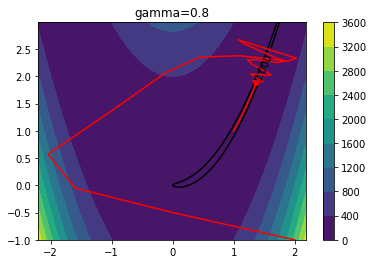

探究折扣因子的影响2：参数gamma=0.6时（小一点点的gamma）
the start point is: [ 2 -1]
the end point is: [0.999888210905285 0.999775986942254]
where the function value is:0.000000
and the contour is as follow:


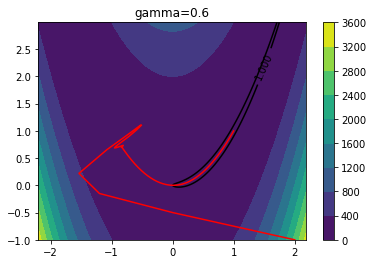

In [5]:
# N=2的rosenbrock_func
f_2, df_2, x_2 = rosenbrock_func(N = 2)
print("探究折扣因子的影响1：参数gamma=0.8时（大gamma）")
momentum_method(f_2, df_2, x_2, x0 = np.array([2,-1]), gamma = 0.8, learning_rate = 5e-4)
print("探究折扣因子的影响2：参数gamma=0.6时（小一点点的gamma）")
momentum_method(f_2, df_2, x_2, x0 = np.array([2,-1]), gamma = 0.6, learning_rate = 5e-4)

**结论：**上面的等高线（contour）及其上的迭代点变化曲线**（红色的线开始于[2,-1]， 结束于[1,1]）**即为所求，[1,1]点对应函数的全局最小值0，说明求解正确。另外由上图对比可以看到一些**momentum方法的性质：**
1. 当折扣率（gamma）较大时，下一步的梯度方向没那么容易改变过来，即震荡比较明显
2. 当折扣率（gamma）较小时，震荡不会很明显，但是更新更慢

#### （2）当N=7时，给出最优解；并且画图展示函数值、函数梯度随迭代的变化示意图，建议给出函数的可视化图

探究折扣因子的影响1：参数gamma=0.8时（大gamma）
the start point is: [0.5488135  0.71518937 0.60276338 0.54488318 0.4236548  0.64589411
 0.43758721]
the end point is: [0.999997322883442 0.999994635726507 0.999989246325155 0.999978439827265
 0.999956772729719 0.999913331386014 0.999826236993468]
where the function value is:0.000000
and the statistic curves is as follow:


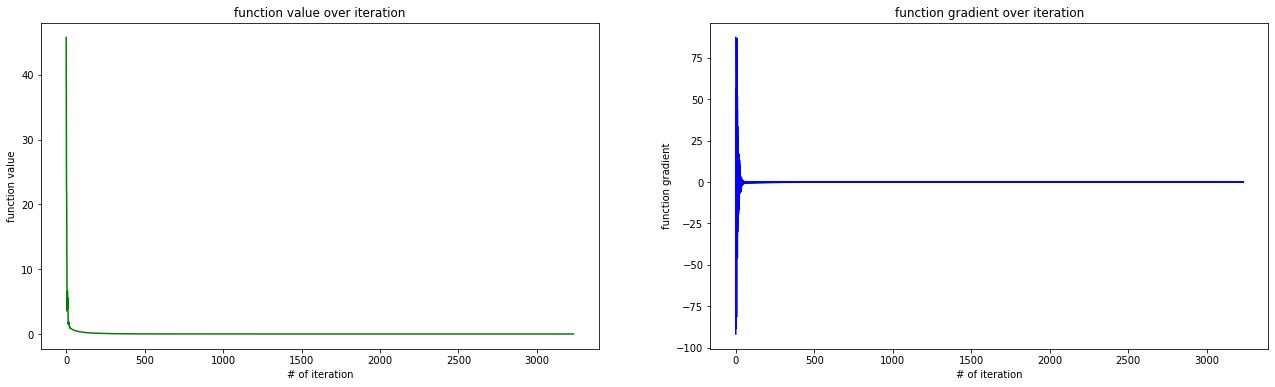

探究折扣因子的影响2：参数gamma=0.6时（较小gamma）
the start point is: [0.5488135  0.71518937 0.60276338 0.54488318 0.4236548  0.64589411
 0.43758721]
the end point is: [0.999997323677360 0.999994637317322 0.999989249514237 0.999978446221082
 0.999956785548964 0.999913357087504 0.999826288520588]
where the function value is:0.000000
and the statistic curves is as follow:


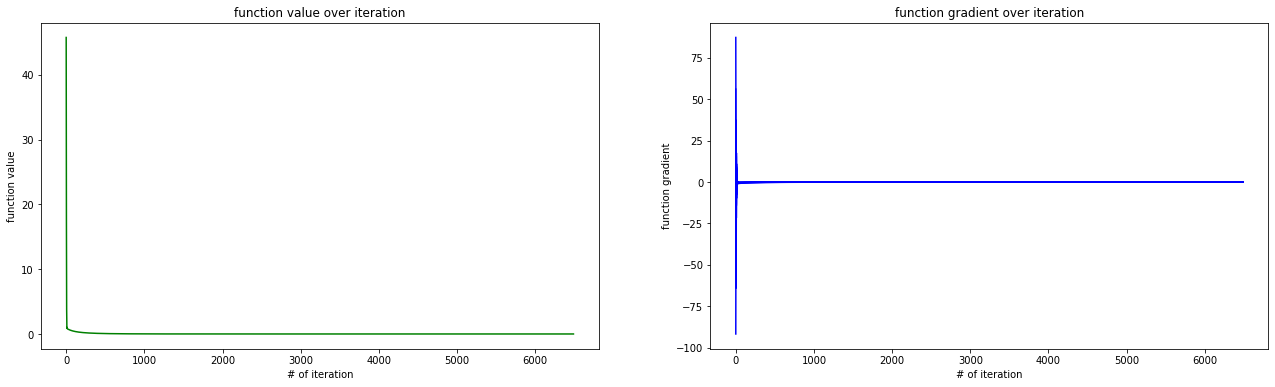

In [6]:
# N=7的rosenbrock_func
f_7, df_7, x_7 = rosenbrock_func(N = 7)
np.random.seed(0)
x0 = np.random.rand(7)
print("探究折扣因子的影响1：参数gamma=0.8时（大gamma）")
momentum_method(f_7, df_7, x_7, x0, gamma = 0.8, learning_rate = 1e-3)
print("探究折扣因子的影响2：参数gamma=0.6时（较小gamma）")
momentum_method(f_7, df_7, x_7, x0, gamma = 0.6, learning_rate = 1e-3)

**结论：**上边的函数值、函数梯度随迭代的变化示意图即为所求，可见收敛还是很快，且都收敛到了7维空间中全1的点（全局极小点），另外同样的由不同折扣因子gamma的对比可以看到**momentum方法的性质：**
1. 当折扣率（gamma）较大时，下一步的梯度方向没那么容易改变过来，即gamma越大震荡越明显
2. 当折扣率（gamma）较小时，震荡不明显，但是更新会慢，比如达到相同的终止性条件，gamma=0.6时的iteration数比gamma=0.8时的iteration数多出一倍

----------

## 第2题（NAG算法）
### a.NAG算法
全称是Nesterov's Accelerated Gradient，是基于momentum的加速算法。那么相较momentum而言有什么优势？因为momentum算法的一个缺点在于——即使当前梯度为0了，由于动量的存在还会继续更新权重，所以NAG的做法是：**用下一步预期的梯度作为当前的指导，也即提前看了一步**。  
所以具体实现时也就在momentum迭代式的基础上修改了一小点（注意下一步预期的位置是只是受到“黏滞阻力”，无“重力”作用，因为快收敛时“重力”几乎为0了）：  
$\left\{\begin{array}{l}v_{j}=\gamma v_{j-1}-\eta g\left(w_{j-1}+\gamma v_{j-1}\right) \\ w_{j}=w_{j-1}+v_{j}\end{array}\right.$  
其中$\gamma$为折扣因子，表示历史梯度的影响

### b.目标函数
$$f(x)=0.1 x_{1}^{2}+2 x_{2}^{2}$$  
函数三维构造如图：

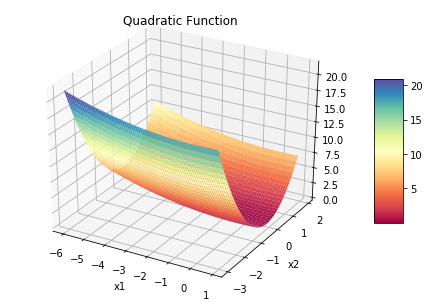

In [7]:
fig = plt.figure()
ax = Axes3D(fig)
x=np.arange(-6,1,0.1)
y=np.arange(-3,2,0.1)
X, Y = np.meshgrid(x, y)
# N=2时的Rosenbrock函数
Z=0.1 * X**2 + 2 * Y**2
#画图
plt.xlabel('x1')
plt.ylabel('x2')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.get_cmap('Spectral'))
plt.title("Quadratic Function")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

由上图可见这显然是一个**“山谷”**函数

In [8]:
x1 = symbols("x1")
x2 = symbols("x2")
x = np.array([x1, x2])
f = 0.1 * x1**2 + 2 * x2**2
df = [diff(f, x_) for x_ in x]

#### 下面实现NAG算法

In [9]:
#辅助函数
def plot_contour_2(xk_summary, gamma, learning_rate):
    x=np.arange(-6,1,0.1)
    y=np.arange(-3,2,0.1)
    X,Y=np.meshgrid(x,y)
    Z =0.1 * X**2 + 2 * Y**2
    C=plt.contour(X,Y,Z,8,locator=ticker.LogLocator(),colors='black')
    plt.contourf(X,Y,Z,8)
    plt.clabel(C,inline=1,fontsize=10)
    plt.colorbar()
    # 迭代点变化
    plt.plot(xk_summary[:,0], xk_summary[:,1],'-',color='red')
    plt.title("gamma=%.2f; learning_rate=%.3f"%(gamma, learning_rate))
    plt.show()
    
def print_result_2(x0, best_point, best_value, xk_summary, gamma, learning_rate):
    print("the start point is:",end=" ")
    print(x0)
    print("the end point is:",end=" ")
    print(best_point)
    print("where the function value is:%f"%(best_value))
    print("and the contour is as follow:")
    plot_contour_2(xk_summary, gamma, learning_rate)

###### MAIN #####
#  NAG算法实现！#
#################
def NAG_method(f, df, x, x0, gamma, learning_rate):
    xk = x0
    vk = 0
    g = np.array([df_k.subs(zip(x,xk)) for df_k in df])
    xk_summary = [x0]
    while sqrt(np.sum([x ** 2 for x in g])) >= 1e-4:
        vk = gamma*vk - learning_rate*np.array([df_k.subs(zip(x,xk + gamma*vk)) for df_k in df])
        xk = xk + vk
        g = np.array([df_k.subs(zip(x,xk)) for df_k in df])
#         print(xk)
        xk_summary.append(xk)
    print_result_2(x0, xk, f.subs(zip(x, xk)), np.array(xk_summary), gamma, learning_rate)

尝试不同的学习率，动量系数，对算法的影响

大学习率；大动量系数（gamma）
the start point is: [-5 -2]
the end point is: [5.91662142045971e-5 2.14796408904584e-5]
where the function value is:0.000000
and the contour is as follow:


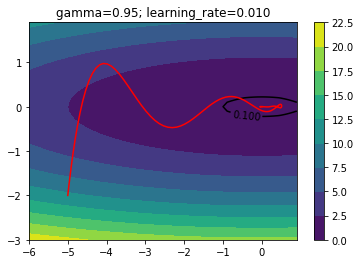

大学习率；小动量系数（gamma）
the start point is: [-5 -2]
the end point is: [-0.000498957184805692 -6.17330027714589e-97]
where the function value is:0.000000
and the contour is as follow:


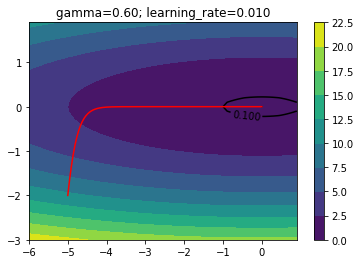

小学习率；大动量系数（gamma）
the start point is: [-5 -2]
the end point is: [-0.000499294514766988 3.29633950693967e-26]
where the function value is:0.000000
and the contour is as follow:


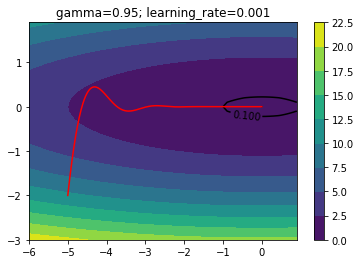

小学习率；小动量系数（gamma）
the start point is: [-5 -2]
the end point is: [-0.000499819298777463 -1.58164887003718e-81]
where the function value is:0.000000
and the contour is as follow:


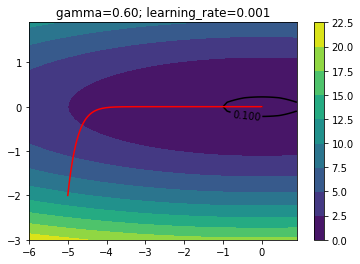

In [10]:
#尝试不同的学习率，动量系数
print("大学习率；大动量系数（gamma）")
NAG_method(f, df, x, x0 = np.array([-5,-2]), gamma = 0.95, learning_rate = 1e-2)
print("大学习率；小动量系数（gamma）")
NAG_method(f, df, x, x0 = np.array([-5,-2]), gamma = 0.6, learning_rate = 1e-2)
print("小学习率；大动量系数（gamma）")
NAG_method(f, df, x, x0 = np.array([-5,-2]), gamma = 0.95, learning_rate = 1e-3)
print("小学习率；小动量系数（gamma）")
NAG_method(f, df, x, x0 = np.array([-5,-2]), gamma = 0.6, learning_rate = 1e-3)

**结论：**都能正确找到最优解
1. 学习率的影响：从收敛速度而言，大学习率能更快收敛、耗时较小；小学习率收敛相对慢一些、耗时较长。从震荡程度而言，大学习率震荡幅度更大（而且可能还会越过最优值，再返回来优化），而小学习率震荡幅度小。
2. 动量系数（gamma）的影响：其实前面第一题也已经分析过了，gamma较大时，保留的历史梯度信息多，不能及时纠正过来，容易震荡，但加速效果好，耗时短；而gamma较小时，相对来说震荡幅度会减弱，且加速效果相对而言差了一些。可以考虑gamma=0的极端情况，这时就退化为普通的梯度下降方法了！

---

## 第3题（概念题）
对比下面的算法结构：
$$w_{k+1} \leftarrow w_{k}-\alpha_{k} H_{k} \nabla F\left(w_{k}\right)$$
$$w_{k+1} \leftarrow w_{k}-\alpha_{k} H_{k} g\left(w_{k}, \xi_{k}\right)$$  

本题中我们认为$H_{k}$是海森矩阵（Hessian matrix）的逆（对应于牛顿法），或者是其近似矩阵（对应于拟牛顿法），总之其蕴含了二阶信息。  
第一个式子是一个全梯度更新的（拟）牛顿型算法（如BFGS算法）；第二个式子是随机采样进行梯度估计的（拟）牛顿型算法（如随机BFGS算法）。  

（1）由于引入了海森矩阵（Hessian matrix）的逆$H_{k}$对梯度方向进行校正，而海森矩阵（Hessian matrix）是二阶信息，因此此类结构是二阶算法。  
（2）$H_{k}$前面也说到了是海森矩阵（Hessian matrix）的逆（或其近似），其意义在于引入二阶信息对梯度方向进行矫正，从而更有效地梯度下降。二阶算法的优势有两点：
1. 具有尺度不变性，上课时已经证明过本题研究的牛顿性算法满足尺度不变性。  
2. 每一步迭代相当于最小化函数值在当前点的二阶泰勒展开式，也即能根据二阶的局部信息进行连续的局部矫正。  

（3）确定性算法和随机算法的区别：本题第一个式子是全梯度更新的牛顿型算法，是确定性算法，一般用于样本不那么大时，用全局的信息进行更新优化是更精确的；而第二个式子是随机样本采样进行更新的牛顿型算法，一般是实际应用中含有大量样本，通常使用小批量随机梯度，使得算法在统计意义下逼近，优势在于随机梯度的估计比使用全部训练数据计算出来要快得多，当然估计的准确性偏差是一个tradeoff。一个典型的例子是学过的随机BFGS算法。
